<a href="https://colab.research.google.com/github/midaasyafii-sys/Tubes-Fintech-Occupation-Outcomes/blob/main/Tubes_Fintech_5_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================
# BAGIAN 1: DATA LOADING & EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print(">>> MEMULAI PROSES ANALISIS DATA...\n")

# 1. LOAD DATA
# Ganti nama file sesuai file yang kamu upload
url_dataset = 'https://raw.githubusercontent.com/midaasyafii-sys/Tubes-Fintech-Occupation-Outcomes/refs/heads/main/Occupations.csv'
try:
    df = pd.read_csv(url_dataset)
    print("[SUCCESS] Data berhasil dimuat.")
except Exception as e:
    print(f"[ERROR] Gagal memuat data: {e}. Pastikan URL atau file CSV benar.")
    df = pd.DataFrame() # Initialize df as an empty DataFrame to prevent NameError later

if not df.empty:
    # 2. DATA CLEANING (Standard)
    # Hapus baris yang targetnya (Income) kosong
    df_clean = df.dropna(subset=['Income']).copy()

    # Isi data kosong (Imputasi)
    for col in df_clean.select_dtypes(include='number').columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    for col in df_clean.select_dtypes(include='object').columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])

    # 3. STATISTIK DESKRIPTIF (Untuk Bahan Analisis)
    print("\n" + "="*40)
    print("   HASIL EKSPLORASI DATA (INSIGHT)")
    print("="*40)

    # Statistik Numerik
    rata_usia = df_clean['Age'].mean()
    rata_jam = df_clean['HoursPerWeek'].mean()

    # Statistik Kategorikal
    top_job = df_clean['Occupation'].mode()[0]
    distribusi_income = df_clean['Income'].value_counts(normalize=True) * 100

    print(f"1. Profil Responden:")
    print(f"   - Rata-rata Usia      : {rata_usia:.1f} tahun")
    print(f"   - Rata-rata Jam Kerja : {rata_jam:.1f} jam/minggu")
    print(f"2. Dominasi Pekerjaan    : '{top_job}'")
    print(f"3. Isu Imbalance Data:")
    print(f"   - Income <=50K (Mayoritas) : {distribusi_income.max():.2f}%")
    print(f"   - Income >50K  (Minoritas) : {distribusi_income.min():.2f}%")

    if distribusi_income.min() < 30:
        print("\n[REKOMENDASI AI]: Terdeteksi ketimpangan data ekstrem (<30%).")
        print("Wajib menggunakan teknik SMOTE pada tahap selanjutnya.")
    else:
        print("\n[INFO]: Data cukup seimbang.")
else:
    print("[INFO]: Tidak ada data untuk diproses karena gagal dimuat.")

>>> MEMULAI PROSES ANALISIS DATA...

[SUCCESS] Data berhasil dimuat.

   HASIL EKSPLORASI DATA (INSIGHT)
1. Profil Responden:
   - Rata-rata Usia      : 38.2 tahun
   - Rata-rata Jam Kerja : 40.3 jam/minggu
2. Dominasi Pekerjaan    : 'Prof-specialty'
3. Isu Imbalance Data:
   - Income <=50K (Mayoritas) : 75.91%
   - Income >50K  (Minoritas) : 24.09%

[REKOMENDASI AI]: Terdeteksi ketimpangan data ekstrem (<30%).
Wajib menggunakan teknik SMOTE pada tahap selanjutnya.


**Interpretasi Data Statistik**

Profil Demografi :

Rata-rata usia responden adalah 38.2 tahun, yang mengindikasikan bahwa mayoritas data berasal dari kelompok usia produktif yang matang (prime working age).

Rata-rata jam kerja tercatat sebesar 40.3 jam/minggu. Angka ini sejalan dengan standar jam kerja global (40 jam/minggu), menandakan data ini bersih dari noise nilai ekstrem yang tidak wajar.


---


Dominasi Sektor Pekerjaan :

Kategori pekerjaan yang paling dominan adalah 'Prof-specialty' (Tenaga Profesional/Spesialis). Hal ini menunjukkan bahwa dataset ini memiliki representasi yang kuat dari kalangan pekerja berkeahlian khusus.


---


Diagnosis Ketimpangan Kelas (Class Imbalance) :

Ditemukan disparitas yang signifikan pada target variabel pendapatan:

*   Kelas Mayoritas (Income <=50K): 75.91%
*   Kelas Minoritas (Income >50K): 24.09%


Implikasi Teknis: Proporsi minoritas yang berada di bawah ambang batas kritis (30%) mengonfirmasi bahwa dataset ini tidak seimbang. Jika kondisi ini dibiarkan, model akan memiliki bias prediksi ke arah pendapatan rendah.


---


Tindakan Lanjut : Sesuai rekomendasi sistem, teknik SMOTE (Synthetic Minority Over-sampling Technique) mutlak diperlukan pada tahap preprocessing selanjutnya untuk menyeimbangkan distribusi kelas sebelum pelatihan model.

In [ ]:
# ==============================================================================
# BLOK 2: PREPROCESSING & SMOTE (PENYEIMBANGAN DATA)
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

print(">>> MEMULAI TAHAP PREPROCESSING & SMOTE...\n")

# 1. ENCODING (Ubah Teks jadi Angka)
# Mesin hanya mengerti angka, jadi kita ubah 'Sales', 'Male', dll jadi 0, 1, 2...
df_model = df_clean.copy()
le = LabelEncoder()

# Encode Target
df_model['Income'] = le.fit_transform(df_model['Income'])

# Encode Fitur Lain
for col in df_model.select_dtypes(include='object').columns:
    df_model[col] = le.fit_transform(df_model[col])

# Pisahkan X (Fitur) dan y (Target)
X = df_model.drop('Income', axis=1)
y = df_model['Income']

# 2. SPLITTING (Bagi Data 70:30)
# 70% untuk Latihan (Training), 30% untuk Ujian (Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Status Splitting:")
print(f"-> Data Training (Awal) : {len(X_train)} baris")
print(f"-> Data Testing         : {len(X_test)} baris")

# 3. PENERAPAN SMOTE
# Hanya diterapkan pada Training Data agar Testing Data tetap murni
print("\n[PROSES SMOTE SEDANG BERJALAN...]")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 4. CEK HASIL
count_awal = y_train.value_counts()
count_akhir = y_train_smote.value_counts()

print("\n" + "="*40)
print("   HASIL PENYEIMBANGAN DATA (SMOTE)")
print("="*40)
print("1. Sebelum SMOTE (Training Set):")
print(f"   - Income Rendah (0): {count_awal[0]} orang")
print(f"   - Income Tinggi (1): {count_awal[1]} orang (Jomplang)")

print("\n2. Setelah SMOTE (Training Set):")
print(f"   - Income Rendah (0): {count_akhir[0]} orang")
print(f"   - Income Tinggi (1): {count_akhir[1]} orang (SEIMBANG!)")

print(f"\n[INFO]: Data siap digunakan untuk Modeling.")
print(f"Total data latih bertambah dari {len(X_train)} menjadi {len(X_train_smote)}.")

>>> MEMULAI TAHAP PREPROCESSING & SMOTE...

Status Splitting:
-> Data Training (Awal) : 111192 baris
-> Data Testing         : 47655 baris

[PROSES SMOTE SEDANG BERJALAN...]

   HASIL PENYEIMBANGAN DATA (SMOTE)
1. Sebelum SMOTE (Training Set):
   - Income Rendah (0): 84326 orang
   - Income Tinggi (1): 26866 orang (Jomplang)

2. Setelah SMOTE (Training Set):
   - Income Rendah (0): 84326 orang
   - Income Tinggi (1): 84326 orang (SEIMBANG!)

[INFO]: Data siap digunakan untuk Modeling.
Total data latih bertambah dari 111192 menjadi 168652.


**Analisis Hasil Preprocessing & SMOTE**

**Evaluasi Penyiapan Data**

Data Splitting :

*   Dataset telah berhasil dipisahkan dengan proporsi 70:30.
*   Sebanyak 111.192 data dialokasikan sebagai Training Set (Data Latih) untuk pembelajaran model
*   Sebanyak 47.655 data dialokasikan sebagai Testing Set (Data Uji) untuk validasi performa. Jumlah data uji yang besar ini menjamin hasil evaluasi yang objektif dan representatif.


---


Penanganan Ketimpangan (Class Imbalance):

1.   Kondisi Awal  : Pada data latih, ditemukan disparitas yang sangat tajam antara kelas pendapatan rendah (84.326 sampel) dan pendapatan tinggi (26.866 sampel). Rasio ketimpangan ini berpotensi menyebabkan bias mayoritas pada model.

2.   Intervensi SMOTE : Teknik Synthetic Minority Over-sampling Technique (SMOTE) diterapkan untuk menyeimbangkan kelas. Algoritma berhasil membangkitkan data sintetis sehingga jumlah kelas minoritas meningkat menyamai kelas mayoritas.

3. Hasil Akhir: Kini kedua kelas memiliki jumlah yang setara, yaitu masing-masing 84.326 sampel. Total data latih meningkat signifikan menjadi 168.652 baris, menciptakan lingkungan pembelajaran yang ideal bagi algoritma klasifikasi.



>>> MEMULAI TRAINING MODEL GRADIENT BOOSTING...

[SUCCESS] Model berhasil dilatih!

   EVALUASI PERFORMA MODEL
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     36247
           1       0.58      0.77      0.66     11408

    accuracy                           0.81     47655
   macro avg       0.75      0.80      0.77     47655
weighted avg       0.84      0.81      0.82     47655



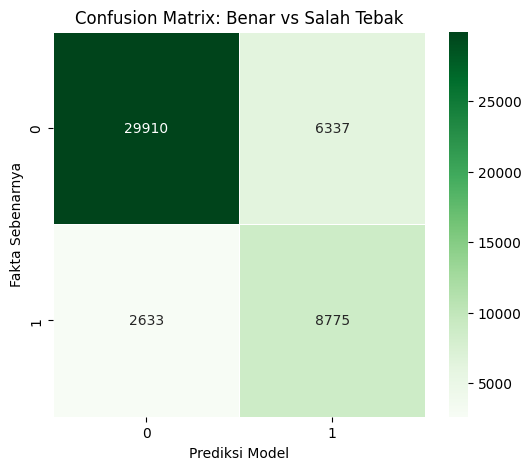

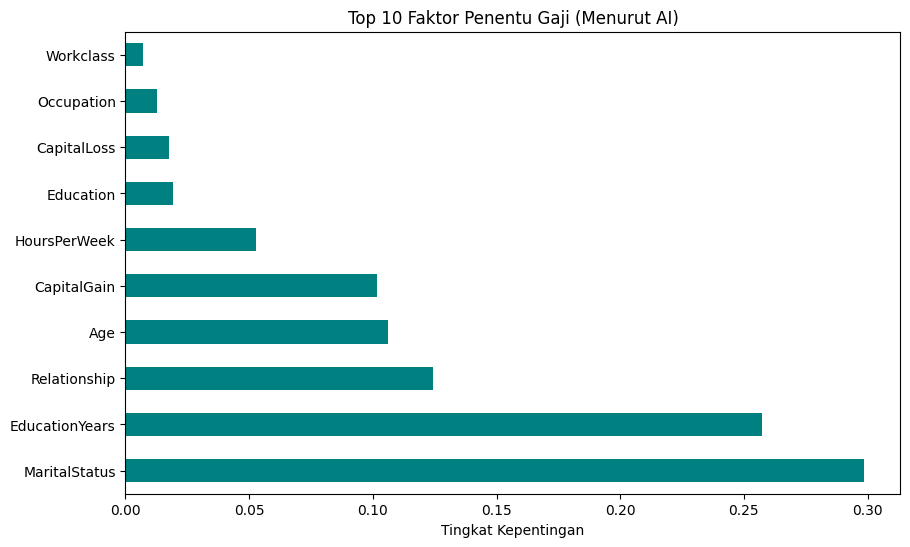

In [ ]:
# ==============================================================================
# BLOK 3: MODELING (GRADIENT BOOSTING) & VISUALISASI
# ==============================================================================
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

print(">>> MEMULAI TRAINING MODEL GRADIENT BOOSTING...\n")

# 1. TRAINING
# Kita gunakan parameter 'Safe' agar cepat tapi akurat
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train_smote, y_train_smote)

print("[SUCCESS] Model berhasil dilatih!")

# 2. TESTING (EVALUASI)
y_pred = gb_model.predict(X_test)

# 3. REPORT CLASSIFICATION
print("\n" + "="*40)
print("   EVALUASI PERFORMA MODEL")
print("="*40)
print(classification_report(y_test, y_pred))

# 4. VISUALISASI 1: CONFUSION MATRIX
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', linewidths=.5)
plt.title('Confusion Matrix: Benar vs Salah Tebak')
plt.xlabel('Prediksi Model')
plt.ylabel('Fakta Sebenarnya')
plt.show()

# 5. VISUALISASI 2: FEATURE IMPORTANCE
# Apa faktor terpenting menurut AI?
feat_importances = pd.Series(gb_model.feature_importances_, index=X.columns)

plt.figure(figsize=(10, 6))
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title('Top 10 Faktor Penentu Gaji (Menurut AI)')
plt.xlabel('Tingkat Kepentingan')
plt.show()

